In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
tf.random.set_seed(40)
np.random.seed(40)

In [3]:
# Hyperparams
epochs = 20
batch_size = 128
learning_rate = 1e-4

In [4]:
(train_ds, valid_ds), ds_info = tfds.load(
    'fashion_mnist', split=['train', 'test'], 
    shuffle_files=True, as_supervised=True, with_info=True
)

In [5]:
index_label = dict([(index, label) for index, label in enumerate(ds_info.features['label'].names)])

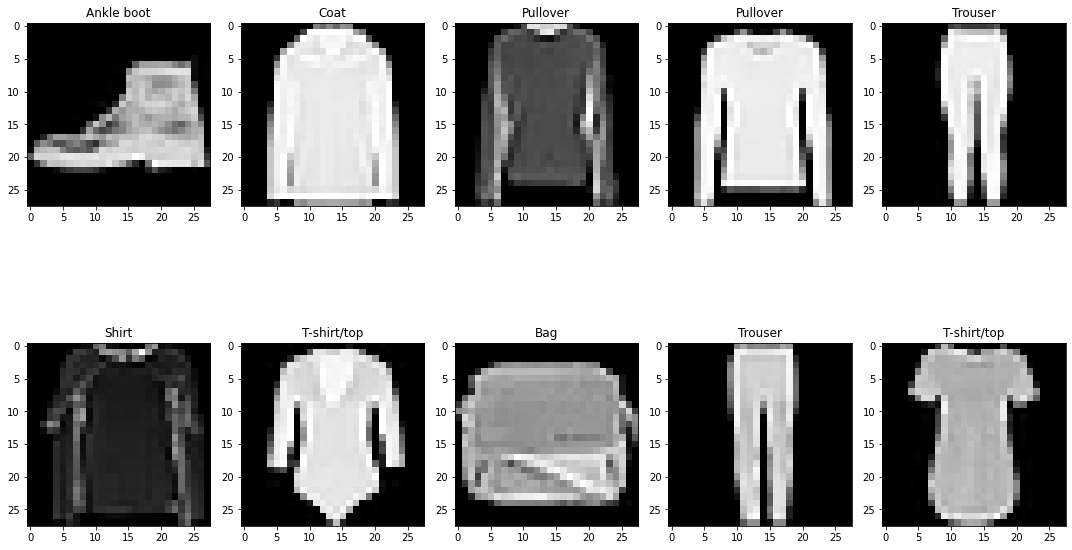

In [6]:
row, column, count = 2, 5, 0
plt.figure(figsize=(15, 10))
for image, label in train_ds.shuffle(10).take(10):
  count += 1
  plt.subplot(row, column, count)
  plt.title(index_label[label.numpy()])
  plt.imshow(image[:,:, 0], cmap='gray')

plt.tight_layout()

In [7]:
@tf.function
def norm_img(image, label):
  image = tf.cast(image, tf.float32)
  return image / 255., label

In [8]:
train_ds = train_ds.shuffle(1024)\
          .batch(batch_size)\
          .map(norm_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
          .prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
valid_ds = valid_ds.shuffle(1024)\
          .batch(batch_size)\
          .map(norm_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
          .prefetch(tf.data.experimental.AUTOTUNE)

# Build model

In [10]:
class Classifier(tf.keras.Model):
  def __init__(self, kernel_init='zeros', bias='zeros'):
    super(Classifier, self).__init__()
    self.flatten = tf.keras.layers.Flatten()
    self.fc1 = tf.keras.layers.Dense(256, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias)
    self.dropout1 = tf.keras.layers.Dropout(0.2)
    self.fc2 = tf.keras.layers.Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias)
    self.dropout2 = tf.keras.layers.Dropout(0.2)
    self.classify = tf.keras.layers.Dense(10, activation='softmax', kernel_initializer=kernel_init, bias_initializer=bias)

  @tf.function
  def call(self, x):
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.dropout1(x)
    x = self.fc2(x)
    x = self.dropout2(x)
    x = self.classify(x)
    return x

In [11]:
model = Classifier(bias='ones', kernel_init='glorot_uniform')

In [12]:
model.build((None, 28, 28, 1))
model.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  200960    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  32896     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
__________________________________________________

# Train with custom training loop

In [13]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
train_metrics = tf.keras.metrics.SparseCategoricalAccuracy()
valid_metrics = tf.keras.metrics.SparseCategoricalAccuracy()

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

In [14]:
@tf.function
def training_step(image, label):
  with tf.GradientTape() as tape:
    logits = model(image, training=True)
    loss_value = loss(label, logits)

  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  train_metrics.update_state(label, logits)
  return loss_value

@tf.function
def test_step(image, label):
  logits = model(image, training=False)
  loss_value = loss(label, logits)
  valid_metrics.update_state(label, logits)
  return loss_value

In [15]:
for epoch in range(epochs):
  for step, (train_image, train_label) in enumerate(train_ds):
    train_loss = training_step(train_image, train_label)

    if step % 500 == 0:
      print(
          "Training loss (for epoch %d) at step %d: %.4f"
          % (epoch, step, float(train_loss))
      )
      print("Seen so far: %s samples" % ((step + 1) * batch_size))

  train_acc = train_metrics.result()
  print("Training acc over epoch %d: %.4f" % (epoch, float(train_acc),))

  for step, (val_image, val_label) in enumerate(valid_ds):
    test_loss = test_step(val_image, val_label)
    if step % 500 == 0:
      print(
          "Training loss (for epoch %d) at step %d: %.4f"
          % (epoch, step, float(train_loss))
      )
      print("Seen so far: %s samples" % ((step + 1) * batch_size))

  val_acc = valid_metrics.result()
  print("Validation acc over epoch %d: %.4f" % (epoch, float(val_acc),))

Training loss (for epoch 0) at step 0: 3.9872
Seen so far: 128 samples
Training acc over epoch 0: 0.6290
Training loss (for epoch 0) at step 0: 0.6105
Seen so far: 128 samples
Validation acc over epoch 0: 0.7463
Training loss (for epoch 1) at step 0: 0.7268
Seen so far: 128 samples
Training acc over epoch 1: 0.7026
Training loss (for epoch 1) at step 0: 0.4929
Seen so far: 128 samples
Validation acc over epoch 1: 0.7656
Training loss (for epoch 2) at step 0: 0.5912
Seen so far: 128 samples
Training acc over epoch 2: 0.7370
Training loss (for epoch 2) at step 0: 0.5054
Seen so far: 128 samples
Validation acc over epoch 2: 0.7789
Training loss (for epoch 3) at step 0: 0.4584
Seen so far: 128 samples
Training acc over epoch 3: 0.7580
Training loss (for epoch 3) at step 0: 0.4314
Seen so far: 128 samples
Validation acc over epoch 3: 0.7871
Training loss (for epoch 4) at step 0: 0.4886
Seen so far: 128 samples
Training acc over epoch 4: 0.7727
Training loss (for epoch 4) at step 0: 0.4514
S

In [16]:
model.compile(metrics=['sparse_categorical_accuracy'])
model.evaluate(valid_ds)

79/79 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.8749


[0.0, 0.8748999834060669]

# Evaluate

In [33]:
from sklearn.metrics import accuracy_score, roc_curve, classification_report, confusion_matrix

In [18]:
(_, test_ds), _ = tfds.load(
    'fashion_mnist', split=['train', 'test'], 
    shuffle_files=True, as_supervised=True, with_info=True
)

In [21]:
@tf.function
def norm_label(image, label):
  return tf.cast(image, tf.float32) / 255. , tf.one_hot(label, 10)

y_true = []
for image, label in test_ds.map(norm_label).batch(1):
  y_true.append(label.numpy())

y_true = np.concatenate(y_true).argmax(axis=1)

In [24]:
y_pred = model.predict(test_ds.batch(batch_size).map(norm_label)).argmax(axis=1)

In [32]:
print('Accuracy: {}'.format(round(accuracy_score(y_true, y_pred) * 100, 2)))
print(classification_report(y_true, y_pred))

Accuracy: 87.49
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1000
           1       0.98      0.97      0.97      1000
           2       0.77      0.81      0.79      1000
           3       0.87      0.89      0.88      1000
           4       0.76      0.83      0.79      1000
           5       0.95      0.94      0.95      1000
           6       0.74      0.61      0.67      1000
           7       0.92      0.94      0.93      1000
           8       0.97      0.97      0.97      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



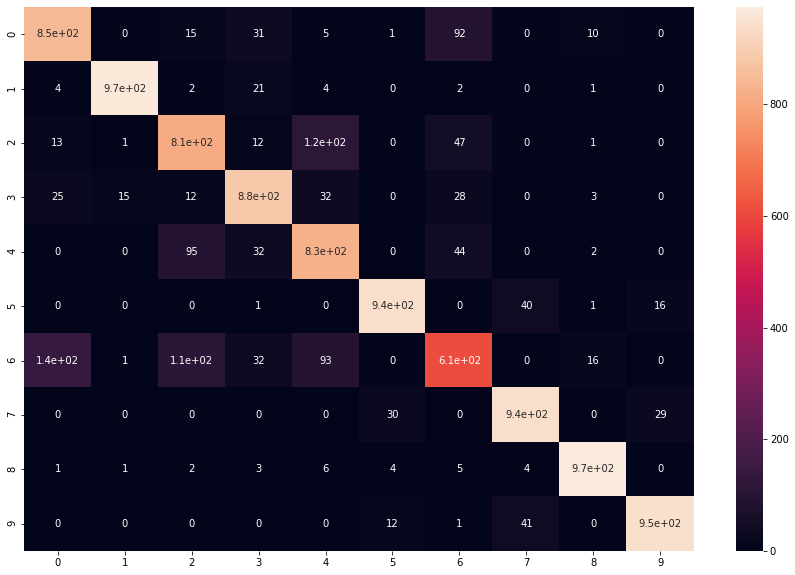

In [30]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)

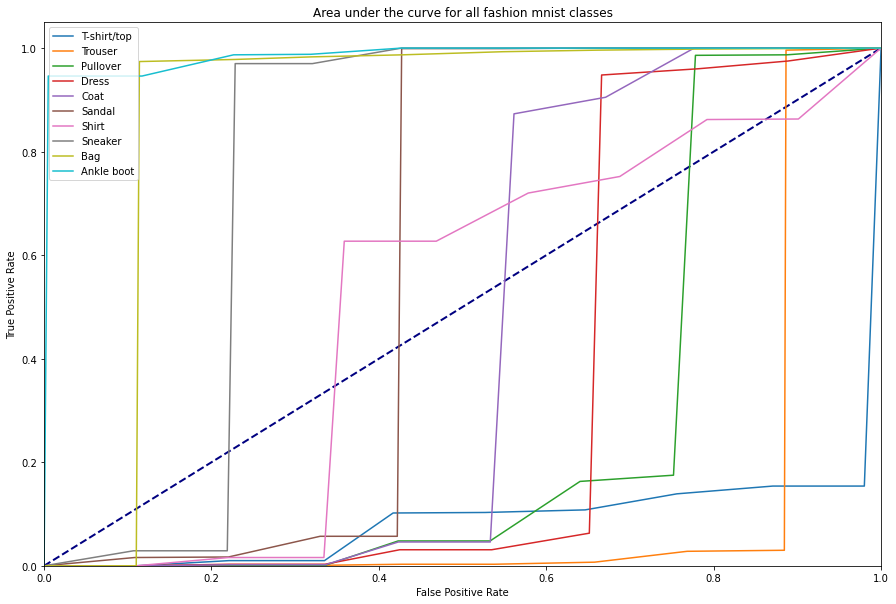

In [50]:
plt.figure(figsize=(15, 10))
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.title('Area under the curve for all fashion mnist classes')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
for i in range(10):
  fpr, tpr, threshold = roc_curve(y_true, y_pred, pos_label=i)
  plt.plot(fpr, tpr, label=index_label[i])

plt.legend()